In [1]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import seaborn as sns
from sklearn.model_selection import train_test_split


In [2]:
#separate train and test train_test_split' 
def train_test_split_local(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
    train_test_split(y, shuffle=False)
    return X_train, X_test, y_train, y_test

#separate train and test LeaveOneGroupOut' 
def LeaveOneGroupOut_local(X, y, groups):
    from sklearn.model_selection import LeaveOneGroupOut
    logo = LeaveOneGroupOut()
    logo.get_n_splits(X, y, groups)

    logo.get_n_splits(groups=groups)  # 'groups' is always required

    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
    
    return X_train, X_test, y_train, y_test, X, y


In [3]:
#Read data
path = 'dataset/' #enter thepath for the dataset folder
header_path = 'header.csv' #enter the path for the header file
header=pd.read_csv(header_path,names=['column',''])['column'].values
users = range(1,5)
trials = range(1,6)
all_data = pd.DataFrame()
for user in users:
    for trial in trials:
        sadl1 = pd.read_csv(path+'S'+str(user)+'-ADL'+str(trial)+'.dat', sep=' ', header=None)
        data = sadl1.iloc[:, :243]
        data.columns = header
        data=data[data.columns[np.r_[0:45,50:58,63:71,76:84,89:97,102:133]]]
        labels = sadl1.iloc[:,243]
        ## Preprocessing data
        #find and remove rows with all nulls
        idx=data.index[data.isnull().all(1)] #1 is the axis for rows
        #select data not in idx, that is data that is not all null
        data = data[~data.index.isin(idx)] 
        #same for labels
        labels = labels[~labels.index.isin(idx)]
        
        #see how many there are of each label
        #what does it mean ?
        labels.value_counts()

    
        #fill missing values
        data = data.fillna(method='ffill',axis=1)
        
        #columns = data.columns[~data.columns.isin(['MILLISEC'])]
        data['user'] = user
        data['trial'] = trial
        columns = data.columns[~data.columns.isin(['user', 'trial','MILLISEC'])]
        #we use a window of 11 elements
        # Filtering using median filter
        filtered_data = data[columns].rolling(11).median()
        filtered_data['MILLISEC'] = data.MILLISEC
        
        
        # Windowing and Feature Extraction
        filtered_data['time']=pd.to_datetime(data.MILLISEC,unit='ms')
        filtered_data.index=filtered_data.time
        #calculate mean over a 1 second window
        keep = filtered_data.time.dt.microsecond/1000 %500
        keep = keep - keep.shift() < 0
        
        means = filtered_data[columns].rolling('1S').mean()[keep]
        means.columns = [str(col) + '_mean' for col in means.columns]
        variances = filtered_data[columns].rolling('1S').var()[keep]
        variances.columns = [str(col) + '_var' for col in variances.columns]
        
        #talk about apply function
        labels.index = filtered_data.time
        mode_labels = labels.rolling('1S').apply(lambda x:mode(x)[0])[keep]
        
        #all features
        all_features = pd.concat([means, variances],axis=1)
        all_features['label'] = mode_labels
        all_features['user'] = user
        all_features['trial'] = trial
        all_data = pd.concat([all_data, all_features])
        
    sadl1 = pd.read_csv(path+'S'+str(user)+'-Drill'+'.dat', sep=' ', header=None)
    data = sadl1.iloc[:, :243]
    data.columns = header
    data=data[data.columns[np.r_[0:45,50:58,63:71,76:84,89:97,102:133]]]
    labels = sadl1.iloc[:,243]
    ## Preprocessing data
    #find and remove rows with all nulls
    idx=data.index[data.isnull().all(1)] #1 is the axis for rows
    #select data not in idx, that is data that is not all null
    data = data[~data.index.isin(idx)] 
    #same for labels
    labels = labels[~labels.index.isin(idx)]

    #see how many there are of each label
    #what does it mean ?
    labels.value_counts()


    #fill missing values
    data = data.fillna(method='ffill',axis=1)

    #columns = data.columns[~data.columns.isin(['MILLISEC'])]
    data['user'] = user
    data['trial'] = 7
    columns = data.columns[~data.columns.isin(['user', 'trial','MILLISEC'])]
    #we use a window of 11 elements
    # Filtering using median filter
    filtered_data = data[columns].rolling(11).median()
    filtered_data['MILLISEC'] = data.MILLISEC


    # Windowing and Feature Extraction
    filtered_data['time']=pd.to_datetime(data.MILLISEC,unit='ms')
    filtered_data.index=filtered_data.time
    #calculate mean over a 1 second window
    keep = filtered_data.time.dt.microsecond/1000 %500
    keep = keep - keep.shift() < 0

    means = filtered_data[columns].rolling('1S').mean()[keep]
    means.columns = [str(col) + '_mean' for col in means.columns]
    variances = filtered_data[columns].rolling('1S').var()[keep]
    variances.columns = [str(col) + '_var' for col in variances.columns]

    #talk about apply function
    labels.index = filtered_data.time
    mode_labels = labels.rolling('1S').apply(lambda x:mode(x)[0])[keep]

    #all features
    all_features = pd.concat([means, variances],axis=1)
    all_features['label'] = mode_labels
    all_features['user'] = user
    all_features['trial'] = 7
    all_data = pd.concat([all_data, all_features])
    

In [4]:
all_data

,Accelerometer_RKN^_accX_mean,Accelerometer_RKN^_accY_mean,Accelerometer_RKN^_accZ_mean,Accelerometer_HIP_accX_mean,Accelerometer_HIP_accY_mean,Accelerometer_HIP_accZ_mean,Accelerometer_LUA^_accX_mean,Accelerometer_LUA^_accY_mean,Accelerometer_LUA^_accZ_mean,Accelerometer_RUA__accX_mean,...,InertialMeasurementUnit_R-SHOE_Body_Az_var,InertialMeasurementUnit_R-SHOE_AngVelBody_FrameX_var,InertialMeasurementUnit_R-SHOE_AngVelBody_FrameY_var,InertialMeasurementUnit_R-SHOE_AngVelBody_FrameZ_var,InertialMeasurementUnit_R-SHOE_AngVelNav_FrameX_var,InertialMeasurementUnit_R-SHOE_AngVelNav_FrameY_var,InertialMeasurementUnit_R-SHOE_AngVelNav_FrameZ_var,label,user,trial
time,,,,,,,,,,,,,,,,,,,,,
1970-01-01 00:00:00.500,1.050000e+02,9.616667e+02,-3.573333e+02,5.000000e-01,1.023167e+03,1.835000e+02,7.466667e+01,1.008667e+03,1.018333e+02,2.453333e+02,...,1.366667,21.766667,14.266667,9.600000,14.266667,21.766667,9.600000,0.0,1,1
1970-01-01 00:00:01.000,4.776190e+01,9.750000e+02,-3.178571e+02,1.061905e+01,1.005667e+03,1.554762e+02,4.761905e+01,1.004619e+03,8.614286e+01,2.394286e+02,...,17.747619,5822.990476,14.228571,309.290476,14.228571,5822.990476,309.290476,0.0,1,1
1970-01-01 00:00:01.500,-3.173333e+01,9.897000e+02,-2.747000e+02,2.093333e+01,1.007933e+03,1.330000e+02,1.196667e+01,1.006100e+03,9.416667e+01,2.448667e+02,...,2257.843678,18485.903448,38647.288506,2476.855172,38647.288506,18485.903448,2476.855172,0.0,1,1
1970-01-01 00:00:02.000,-8.363333e+01,9.920667e+02,-2.688333e+02,-1.293333e+01,1.018167e+03,8.950000e+01,-2.633333e+01,1.001300e+03,1.756667e+02,2.344667e+02,...,2173.636782,16930.562069,43889.972414,1953.374713,43889.972414,16930.562069,1953.374713,0.0,1,1
1970-01-01 00:00:02.500,-1.510000e+01,9.919333e+02,-2.799000e+02,2.600000e+01,1.018567e+03,7.193333e+01,-6.430000e+01,9.774000e+02,3.442333e+02,1.953667e+02,...,129.909195,605.075862,3338.764368,157.567816,3338.764368,605.075862,157.567816,0.0,1,1
1970-01-01 00:00:03.000,1.746667e+01,9.983000e+02,-2.758000e+02,9.496667e+01,1.009200e+03,1.158333e+02,-3.687667e+02,7.155000e+02,4.989000e+02,1.604000e+02,...,96.396552,646.947126,3108.074713,142.024138,3108.074713,646.947126,142.024138,0.0,1,1
1970-01-01 00:00:03.500,-2.540000e+01,9.901000e+02,-2.982667e+02,8.833333e+01,1.014633e+03,1.408667e+02,-4.695667e+02,3.643000e+02,4.478333e+02,1.947000e+02,...,2.179310,198.478161,50.524138,98.271264,50.524138,198.478161,98.271264,0.0,1,1
1970-01-01 00:00:04.000,-2.196667e+01,9.805667e+02,-3.105333e+02,1.118000e+02,1.003267e+03,1.900000e+02,-6.786667e+01,2.589667e+02,3.369333e+02,2.258667e+02,...,1.291954,154.254023,57.995402,88.464368,57.995402,154.254023,88.464368,0.0,1,1
1970-01-01 00:00:04.500,-2.283333e+01,9.782333e+02,-3.176333e+02,1.391000e+02,9.781000e+02,2.451000e+02,-1.357000e+02,2.867667e+02,5.762333e+02,-2.683333e+01,...,6.598851,101.903448,63.581609,62.188506,63.581609,101.903448,62.188506,0.0,1,1


In [5]:

all_data.label.value_counts()

1.0    23172
2.0    13218
0.0    10747
4.0     9119
5.0     1692
Name: label, dtype: int64

In [29]:
all_data.trials.value_counts()

7    14981
1    11513
3     7956
5     7930
2     7863
4     7705
Name: trial, dtype: int64

In [25]:
all_data.users.value_counts()

1    15641
2    15010
3    14455
4    12842
Name: user, dtype: int64

In [10]:
data.describe()

,MILLISEC,Accelerometer_RKN^_accX,Accelerometer_RKN^_accY,Accelerometer_RKN^_accZ,Accelerometer_HIP_accX,Accelerometer_HIP_accY,Accelerometer_HIP_accZ,Accelerometer_LUA^_accX,Accelerometer_LUA^_accY,Accelerometer_LUA^_accZ,...,InertialMeasurementUnit_R-SHOE_Body_Ay,InertialMeasurementUnit_R-SHOE_Body_Az,InertialMeasurementUnit_R-SHOE_AngVelBody_FrameX,InertialMeasurementUnit_R-SHOE_AngVelBody_FrameY,InertialMeasurementUnit_R-SHOE_AngVelBody_FrameZ,InertialMeasurementUnit_R-SHOE_AngVelNav_FrameX,InertialMeasurementUnit_R-SHOE_AngVelNav_FrameY,InertialMeasurementUnit_R-SHOE_AngVelNav_FrameZ,user,trial
count,4.546000e+04,4.546000e+04,4.546000e+04,4.546000e+04,4.546000e+04,4.546000e+04,4.546000e+04,4.546000e+04,4.546000e+04,4.546000e+04,...,45460.000000,45460.000000,45460.000000,45460.000000,45460.000000,45460.000000,45460.000000,45460.000000,45460.0,45460.0
mean,7.576424e+05,7.205346e+04,7.273918e+04,7.213026e+04,7.473093e+03,8.570559e+03,7.912822e+03,5.460099e+03,5.830548e+03,5.107764e+03,...,527.461615,751.195139,15.213308,72.193445,46.187593,72.193445,-12.695095,46.187593,4.0,7.0
std,4.374395e+05,2.770680e+05,2.768902e+05,2.770482e+05,9.730875e+04,9.722217e+04,9.727437e+04,8.701798e+04,8.699683e+04,8.703878e+04,...,463.129698,421.830454,1651.352297,1028.671603,915.979974,1028.671603,1651.373576,915.979974,0.0,0.0
min,0.000000e+00,-2.240000e+03,-7.560000e+02,-1.907000e+03,-1.002000e+03,-5.700000e+01,-1.456000e+03,-2.500000e+02,-7.990000e+02,-1.076000e+03,...,-4985.000000,-5305.000000,-8661.000000,-13377.000000,-15677.000000,-13377.000000,-13458.000000,-15677.000000,4.0,7.0
25%,3.788215e+05,1.110000e+02,9.100000e+02,6.500000e+01,-3.380000e+02,8.510000e+02,1.390000e+02,3.220000e+02,7.490000e+02,-6.000000e+01,...,390.000000,694.000000,-43.000000,-42.000000,-44.000000,-42.000000,-75.000000,-44.000000,4.0,7.0
50%,7.576425e+05,2.090000e+02,1.010000e+03,2.510000e+02,-1.290000e+02,9.180000e+02,3.390000e+02,4.035000e+02,8.620000e+02,1.630000e+02,...,407.000000,799.000000,3.000000,3.000000,-3.000000,3.000000,-3.000000,-3.000000,4.0,7.0
75%,1.136464e+06,3.680000e+02,1.048000e+03,5.560000e+02,-4.800000e+01,9.710000e+02,4.580000e+02,5.570000e+02,9.380000e+02,2.830000e+02,...,547.000000,809.000000,77.000000,77.000000,46.000000,77.000000,44.000000,46.000000,4.0,7.0
max,1.515285e+06,1.515285e+06,1.515285e+06,1.515285e+06,1.515285e+06,1.515285e+06,1.515285e+06,1.515285e+06,1.515285e+06,1.515285e+06,...,7100.000000,5496.000000,13458.000000,9670.000000,6765.000000,9670.000000,8661.000000,6765.000000,4.0,7.0


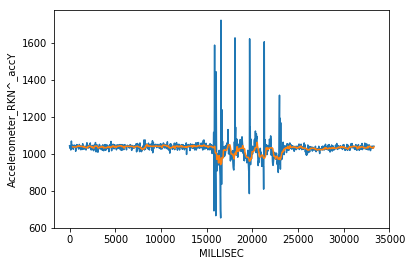

In [57]:
#Plot explore other features
sns.lineplot(x='MILLISEC',y='Accelerometer_RKN^_accY', data=data[:1000])
sns.lineplot(x='MILLISEC',y='Accelerometer_RKN^_accY', data=filtered_data.iloc[:1000])

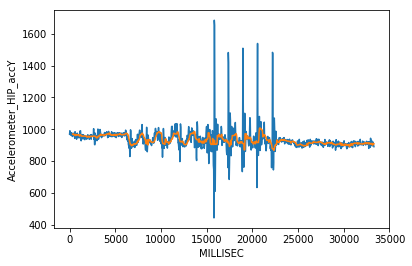

In [60]:
sns.lineplot(x='MILLISEC',y='Accelerometer_HIP_accY', data=data[:1000])
sns.lineplot(x='MILLISEC',y='Accelerometer_HIP_accY', data=filtered_data.iloc[:1000])

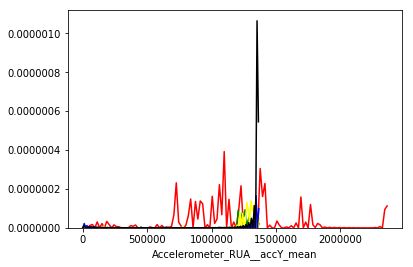

In [11]:
     #explore the data
all_data.label.value_counts()

#separate by class, see feature mean
all_data_0 = all_data[all_data.label==0]
all_data_1 = all_data[all_data.label==1]
all_data_2 = all_data[all_data.label==2]
all_data_4 = all_data[all_data.label==4]
all_data_5 = all_data[all_data.label==5]

draw_col = 10
sns.distplot(all_data_0.iloc[:,draw_col], hist=False, kde=True, color='red')
sns.distplot(all_data_1.iloc[:,draw_col], hist=False, kde=True, color='green')
sns.distplot(all_data_2.iloc[:,draw_col], hist=False, kde=True, color='yellow')
sns.distplot(all_data_4.iloc[:,draw_col], hist=False, kde=True, color='blue')
sns.distplot(all_data_5.iloc[:,draw_col], hist=False, kde=True, color='black')

In [13]:
# Excercise 1
# Random train test split

# Labels are the values we want to predict
labels = np.array(all_data['label'])

# Remove the labels from the features
# axis 1 refers to the columns
features = all_data.drop('label', axis = 1)
features = features.drop('user', axis = 1)
features = features.drop('trial', axis = 1)


# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)


X_train, X_test, y_train, y_test = train_test_split_local(features, labels)

In [14]:
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (38825, 214)
X_test: (19123, 214)
y_train: (38825,)
y_test: (19123,)


In [15]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=20, random_state=0)  
classifier.fit(X_train, y_train)  
y_pred = classifier.predict(X_test)

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  
print(accuracy_score(y_test, y_pred))

[[3169  176  171   19    6]
 [  29 7166  410    7    0]
 [  62  742 3633    4    0]
 [  13   77   17 2842    4]
 [   9    1    1    6  559]]
              precision    recall  f1-score   support

         0.0       0.97      0.89      0.93      3541
         1.0       0.88      0.94      0.91      7612
         2.0       0.86      0.82      0.84      4441
         4.0       0.99      0.96      0.97      2953
         5.0       0.98      0.97      0.98       576

   micro avg       0.91      0.91      0.91     19123
   macro avg       0.93      0.92      0.93     19123
weighted avg       0.91      0.91      0.91     19123

0.9082779898551483


In [17]:
# Excercise 1
# user 1 2 3 train test 4

# Labels are the values we want to predict
# Remove the labels from the features
# axis 1 refers to the columns

user123 = all_data[all_data['user'].isin([1, 2, 3])]
user4 = all_data[all_data['user'].isin([4])]


y_train_2 = np.array(user123['label'])
y_test_2 = np.array(user4['label'])

user123 = user123.drop('label', axis = 1)
user123 = user123.drop('user', axis = 1)
user123 = user123.drop('trial', axis = 1)

user4 = user4.drop('label', axis = 1)
user4 = user4.drop('user', axis = 1)
user4 = user4.drop('trial', axis = 1)

X_train_2 = np.array(user123)
X_test_2 = np.array(user4)



In [18]:
print('X_train_2:', X_train_2.shape)
print('X_test_2:', X_test_2.shape)
print('y_train_2:', y_train_2.shape)
print('y_test_2:', y_test_2.shape)

X_train_2: (45106, 214)
X_test_2: (12842, 214)
y_train_2: (45106,)
y_test_2: (12842,)


In [19]:

classifier2 = RandomForestClassifier(n_estimators=20, random_state=0)  
classifier2.fit(X_train_2, y_train_2)  
y_pred_2 = classifier2.predict(X_test_2)

In [20]:

print(confusion_matrix(y_test_2,y_pred_2))  
print(classification_report(y_test_2,y_pred_2))  
print(accuracy_score(y_test_2, y_pred_2))

[[1950  796  277   13    0]
 [ 102 4411  590   16    0]
 [  58  367 2325    3    0]
 [  70  115   41 1355    0]
 [ 116    6    4   35  192]]
              precision    recall  f1-score   support

         0.0       0.85      0.64      0.73      3036
         1.0       0.77      0.86      0.82      5119
         2.0       0.72      0.84      0.78      2753
         4.0       0.95      0.86      0.90      1581
         5.0       1.00      0.54      0.70       353

   micro avg       0.80      0.80      0.80     12842
   macro avg       0.86      0.75      0.79     12842
weighted avg       0.81      0.80      0.79     12842

0.7968384986762187


In [26]:
# Excercise 1
#  1,2,3 and drill session as training data and trials 4 and 5 as test data.

# Labels are the values we want to predict
# Remove the labels from the features
# axis 1 refers to the columns

trial1237 = all_data[all_data['trial'].isin([1, 2, 3, 7])]
trial45 = all_data[all_data['trial'].isin([4, 5])]

y_train_3 = np.array(trial1237['label'])
y_test_3 = np.array(trial45['label'])

trial1237 = trial1237.drop('label', axis = 1)
trial1237 = trial1237.drop('user', axis = 1)
trial1237 = trial1237.drop('trial', axis = 1)

trial45 = trial45.drop('label', axis = 1)
trial45 = trial45.drop('user', axis = 1)
trial45 = trial45.drop('trial', axis = 1)

X_train_3 = np.array(trial1237)
X_test_3 = np.array(trial45)



In [27]:
print('X_train_3:', X_train_3.shape)
print('X_test_3:', X_test_3.shape)
print('y_train_3:', y_train_3.shape)
print('y_test_3:', y_test_3.shape)

X_train_3: (42313, 214)
X_test_3: (15635, 214)
y_train_3: (42313,)
y_test_3: (15635,)


In [38]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=20, random_state=0)  
classifier.fit(X_train_3, y_train_3)  
y_pred_3 = classifier.predict(X_test_3)

In [39]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test_3,y_pred_3))  
print(classification_report(y_test_3,y_pred_3))  
print(accuracy_score(y_test_3, y_pred_3))

[[1950  796  277   13    0]
 [ 102 4411  590   16    0]
 [  58  367 2325    3    0]
 [  70  115   41 1355    0]
 [ 116    6    4   35  192]]
              precision    recall  f1-score   support

         0.0       0.85      0.64      0.73      3036
         1.0       0.77      0.86      0.82      5119
         2.0       0.72      0.84      0.78      2753
         4.0       0.95      0.86      0.90      1581
         5.0       1.00      0.54      0.70       353

   micro avg       0.80      0.80      0.80     12842
   macro avg       0.86      0.75      0.79     12842
weighted avg       0.81      0.80      0.79     12842

0.7968384986762187
